## **Machine Learning Optimization with Optuna**
*By Cristian Leo*

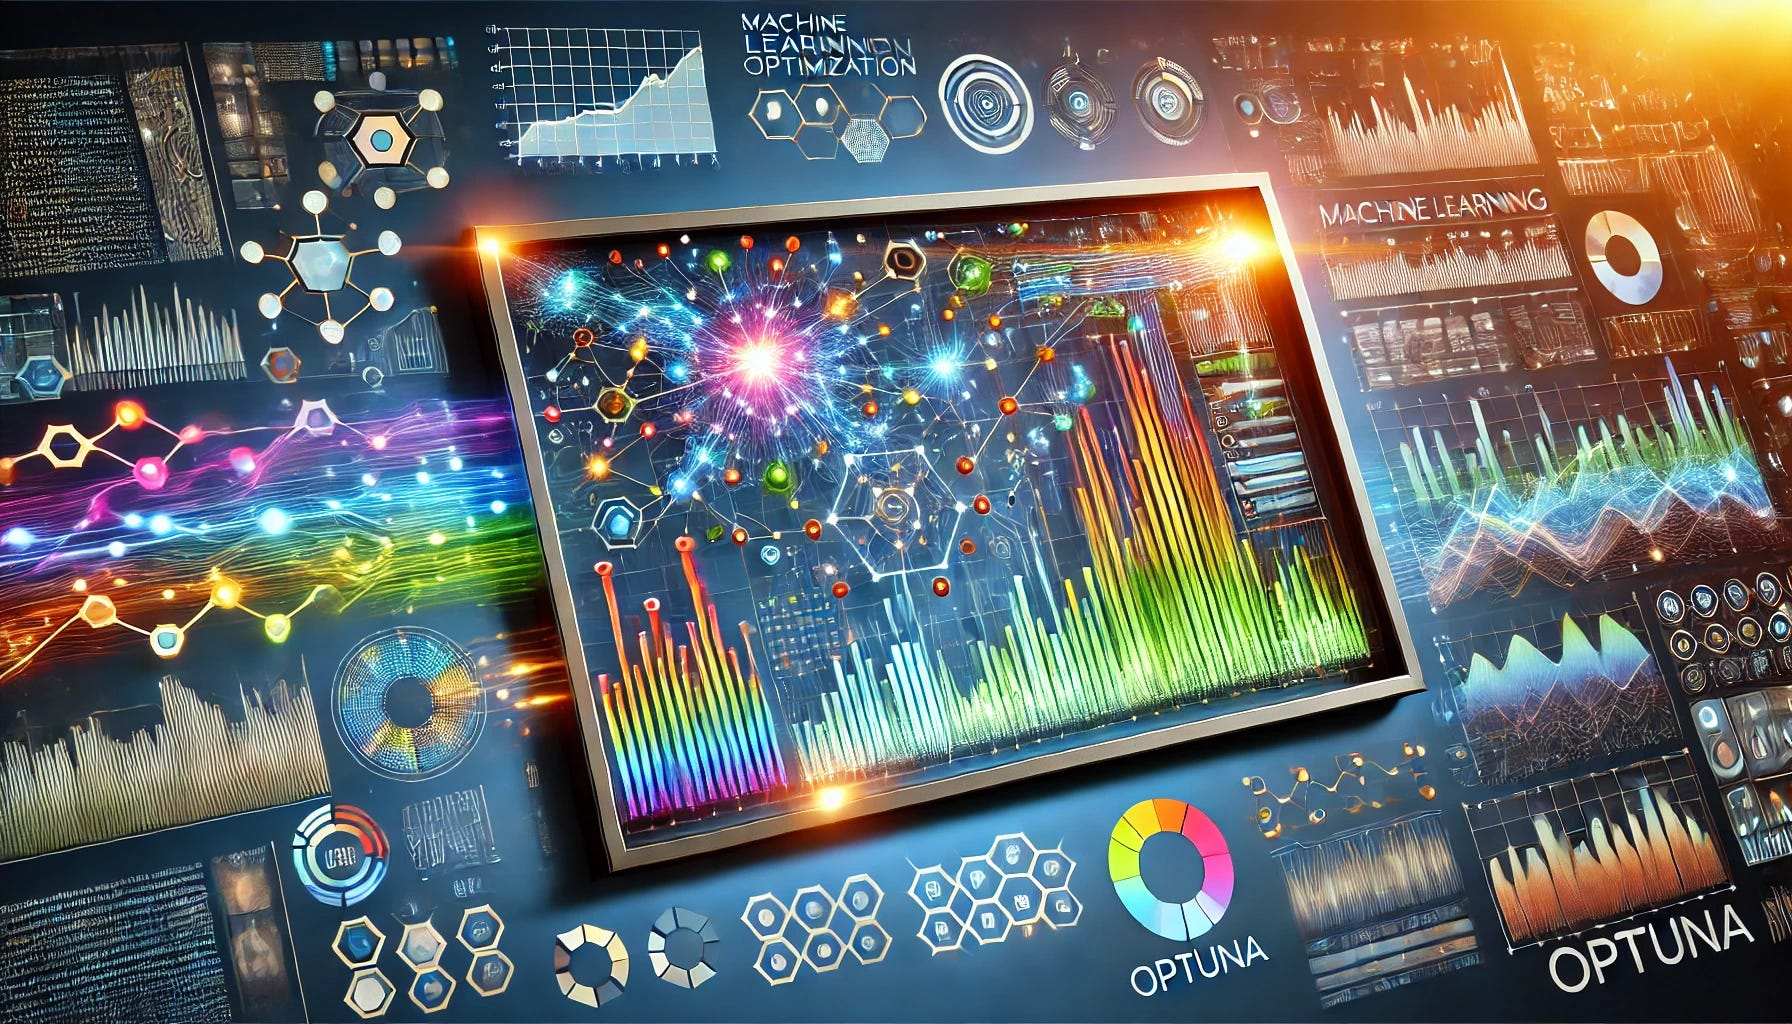

In [1]:
import os
import json
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
# import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice
import gc
gc.collect()

/Users/cristianleo/Documents/Documents - Cristian’s Laptop/GitHub/models-from-scratch-python/venv/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/cristianleo/Documents/Documents - Cristian’s Laptop/GitHub/models-from-scratch-python/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0

In [2]:
train = pd.read_csv('data/train.csv')
test_orig = test.copy()
train.head()

id  Marital status  Application mode  Application order  Course  \
0   0               1                 1                  1    9238   
1   1               1                17                  1    9238   
2   2               1                17                  2    9254   
3   3               1                 1                  3    9500   
4   4               1                 1                  2    9500   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           126.0            1                       1   
1                           125.0            1                      19   
2                           137.0            1                       3   
3                           131.0            1                      19   
4                           132.0            1                      19   

   Father's qualification  Mother's occupation  Father's occupation  \
0                      19                    5                    5   
1                      19                    9                    9   
2                      19                    2                    3   
3                       3                    3                    2   
4                      37                    4                    9   

   Admission grade  Displaced  Educational special needs  Debtor  \
0            122.6          0                          0       0   
1            119.8          1                          0       0   
2            144.7          0                          0       0   
3            126.1          1                          0       0   
4            120.1          1                          0       0   

   Tuition fees up to date  Gender  Scholarship holder  Age at enrollment  \
0                        1       0                   1                 18   
1                        1       0                   0                 18   
2                        1       1                   0                 18   
3                        1       0                   1                 18   
4                        1       0                   0                 18   

   International  Curricular units 1st sem (credited)  \
0              0                                    0   
1              0                                    0   
2              0                                    0   
3              0                                    0   
4              0                                    0   

   Curricular units 1st sem (enrolled)  \
0                                    6   
1                                    6   
2                                    6   
3                                    7   
4                                    7   

   Curricular units 1st sem (evaluations)  \
0                                       6   
1                                       8   
2                                       0   
3                                       9   
4                                      12   

   Curricular units 1st sem (approved)  Curricular units 1st sem (grade)  \
0                                    6                         14.500000   
1                                    4                         11.600000   
2                                    0                          0.000000   
3                                    7                         12.591250   
4                                    6                         12.933333   

   Curricular units 1st sem (without evaluations)  \
0                                               0   
1                                               0   
2           

In [3]:
train['Target'].value_counts(normalize=True)

Target
Graduate    0.474163
Dropout     0.330589
Enrolled    0.195248
Name: proportion, dtype: float64

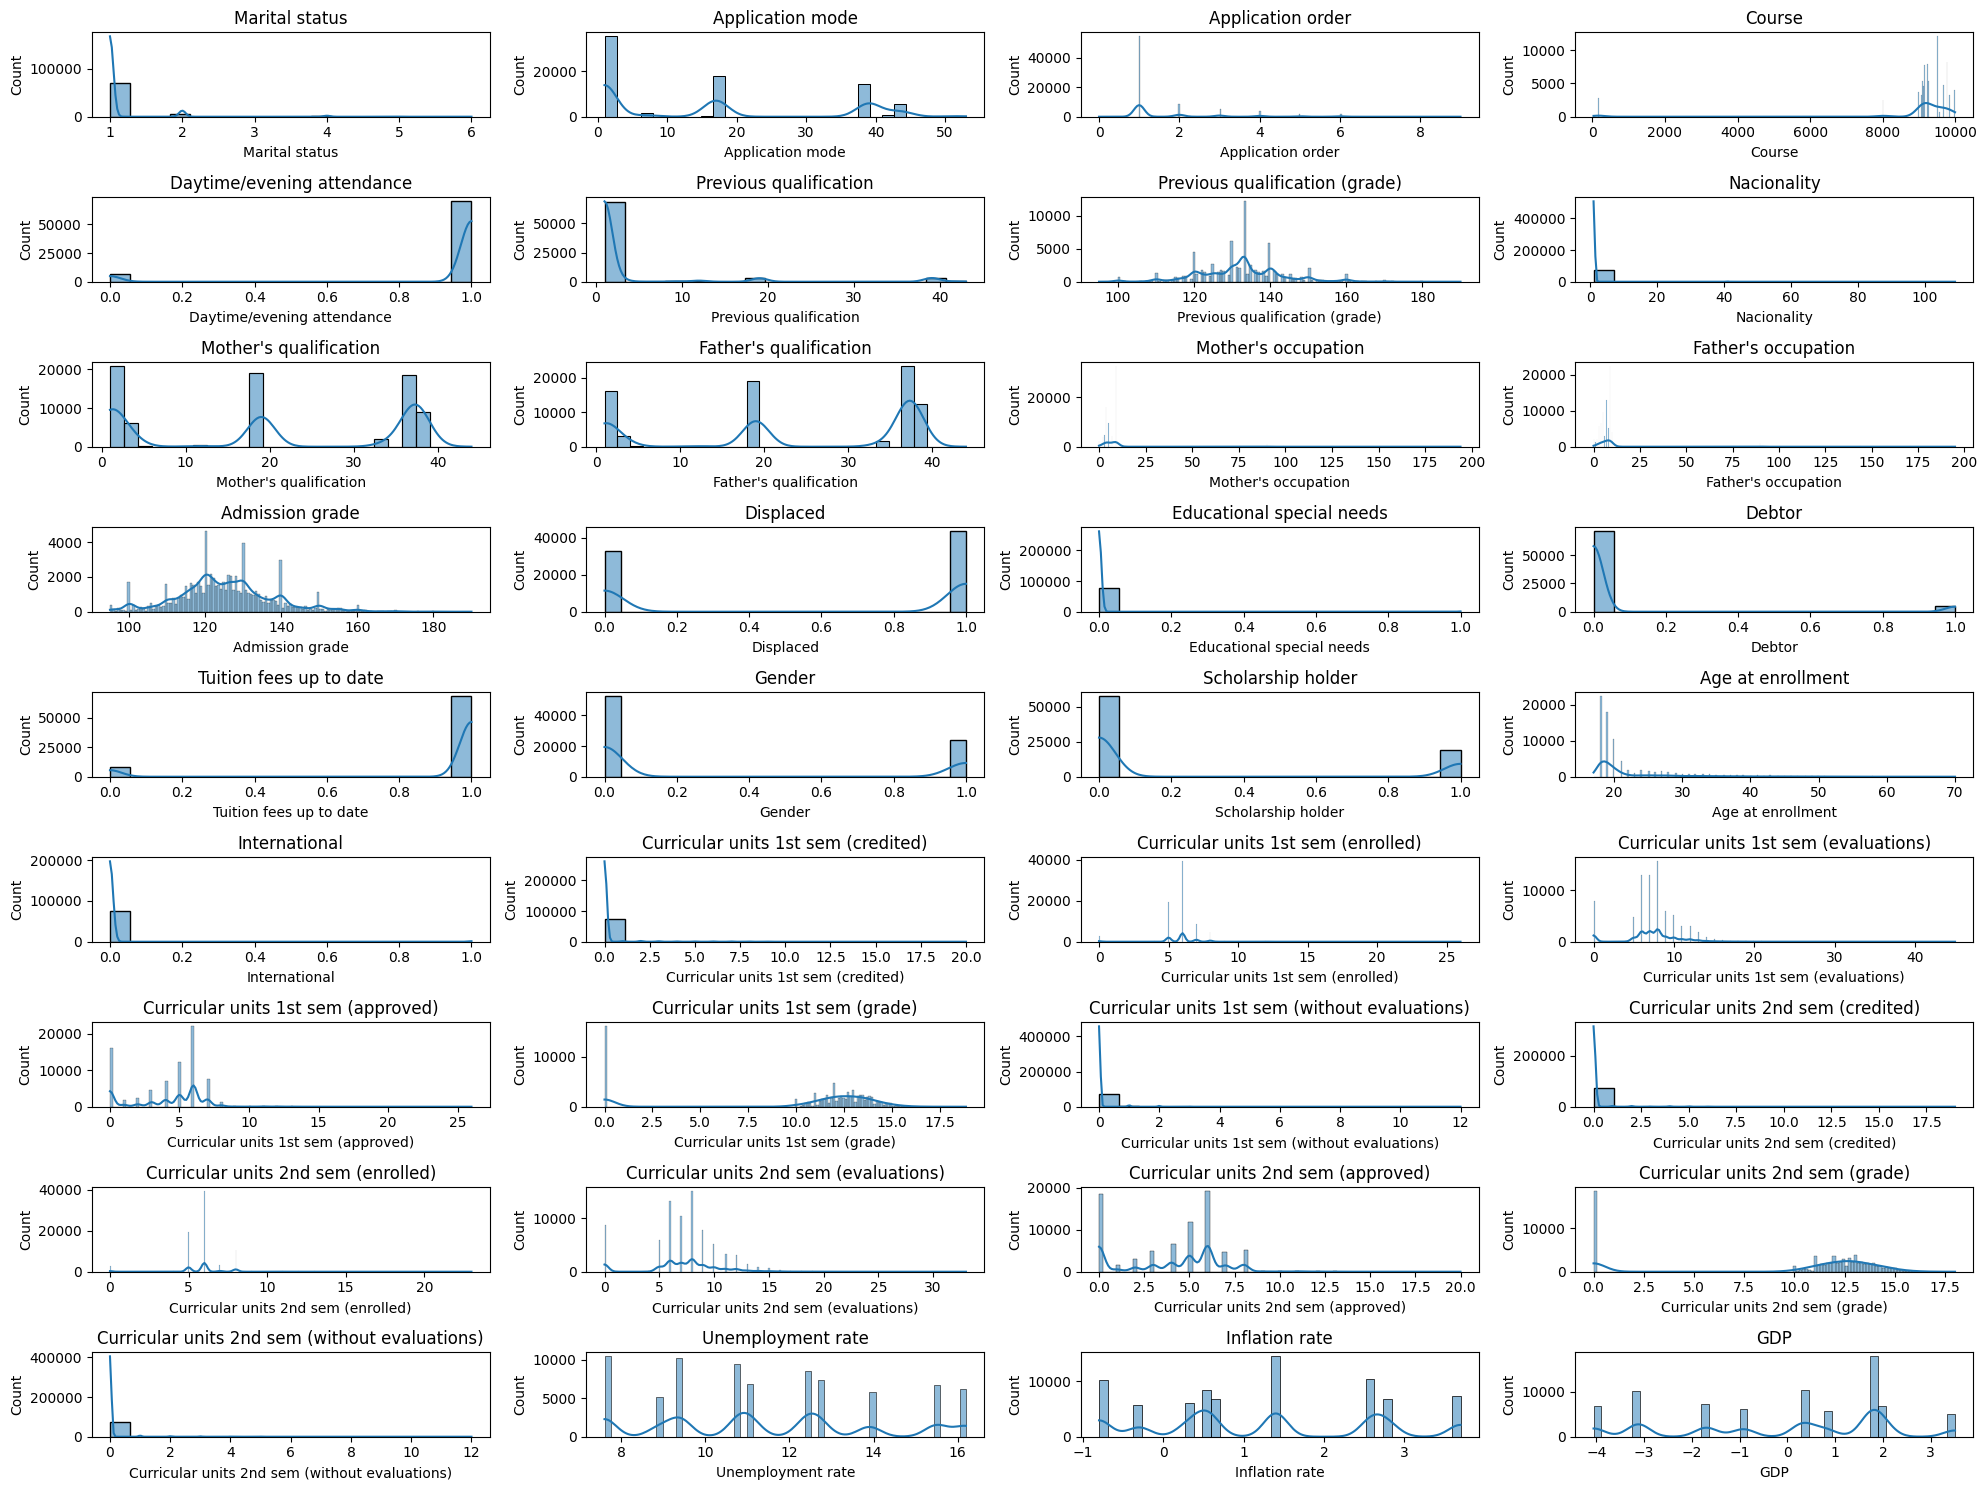

In [4]:
# Number of features to plot
num_features = len(train.columns) - 2  # Excluding the first and last columns

# Define the layout of subplots (rows x columns). Adjust as needed.
num_cols = 4  # Example: 4 rows
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate columns needed

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot
for i, col in enumerate(train.columns[1:-1]):
    sns.histplot(train[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for i in range(num_features, len(axes)):
    axes[i].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [5]:
for col in train.columns[1:-1]:
    if train[col].nunique() <= 20:
        print(f"{col}")
        print(train[col].value_counts(normalize=True))
        print()

Marital status
Marital status
1    0.917287
2    0.069212
4    0.011318
5    0.001516
6    0.000457
3    0.000209
Name: proportion, dtype: float64

Application order
Application order
1    0.710696
2    0.115986
3    0.070101
4    0.049949
5    0.027771
6    0.025445
0    0.000039
9    0.000013
Name: proportion, dtype: float64

Course
Course
9500    0.157793
9773    0.107347
9238    0.103701
9147    0.101166
9254    0.070898
9085    0.070219
9670    0.062208
9991    0.053020
9003    0.048786
9070    0.042879
9853    0.041794
9119    0.039259
171     0.037364
8014    0.031862
9130    0.020989
9556    0.009749
33      0.000941
979     0.000013
39      0.000013
Name: proportion, dtype: float64

Daytime/evening attendance
Daytime/evening attendance
1    0.915314
0    0.084686
Name: proportion, dtype: float64

Nacionality
Nacionality
1      0.993400
41     0.002888
26     0.000876
6      0.000732
22     0.000732
24     0.000196
11     0.000196
2      0.000170
103    0.000157
105    0.000118

In [4]:
cols_to_scale = []

for col in train.columns[1:-1]:
    if train[col].min() < -1 or train[col].max() > 1:
        cols_to_scale.append(col)

print(cols_to_scale)

['Marital status', 'Application mode', 'Application order', 'Course', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']


In [5]:
X, y = train.drop(columns=['id', 'Target']), train['Target'].values
test.drop(columns=['id'], inplace=True)

encoder = OneHotEncoder(categories='auto', sparse_output=False)
y_ohe = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_val, y_train, y_val = train_test_split(X, y_ohe, test_size=0.3, shuffle=True, random_state=42)
print(X_train.shape, y_train.shape)

(53562, 36) (53562, 3)


In [6]:
scaler = StandardScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
test[cols_to_scale] = scaler.transform(test[cols_to_scale])

In [9]:
def optimize_xgb(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': y_train.shape[-1],
        'n_estimators': 100,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_jobs': -1
    }

    xgb_cl = xgb.XGBClassifier(**params)
    xgb_cl.fit(
        X_train, np.argmax(y_train, axis=1),
        eval_set=[(X_val, np.argmax(y_val, axis=1))],
        verbose=0
    )

    y_pred = xgb_cl.predict(X_val)
    acc = np.mean(y_pred == np.argmax(y_val, axis=1))
    return acc

study = optuna.create_study(direction='maximize', study_name='xgb_study', storage='sqlite:///xgb_study.db', load_if_exists=True)
study.optimize(optimize_xgb, n_trials=10, n_jobs=-1, show_progress_bar=True)

[I 2024-06-23 19:18:57,476] Using an existing study with name 'xgb_study' instead of creating a new one.
Best trial: 418. Best value: 0.838996:  10%|█         | 1/10 [00:07<01:03,  7.07s/it]

[I 2024-06-23 19:19:04,504] Trial 460 finished with value: 0.8349451123889179 and parameters: {'max_depth': 5, 'learning_rate': 0.08019580185753591, 'subsample': 0.9442233502156493, 'colsample_bytree': 0.5120208293492529, 'gamma': 0.2969702900907745, 'reg_alpha': 0.032156470508371504, 'reg_lambda': 0.7721092170601993, 'min_child_weight': 8}. Best is trial 418 with value: 0.8389963408259279.
[I 2024-06-23 19:19:04,541] Trial 464 finished with value: 0.8352064819654992 and parameters: {'max_depth': 5, 'learning_rate': 0.07971780856870643, 'subsample': 0.944287593118761, 'colsample_bytree': 0.534672507084035, 'gamma': 0.6243570474362494, 'reg_alpha': 0.23774014567126894, 'reg_lambda': 0.7914988189242819, 'min_child_weight': 1}. Best is trial 418 with value: 0.8389963408259279.


Best trial: 418. Best value: 0.838996:  30%|███       | 3/10 [00:10<00:20,  2.98s/it]

[I 2024-06-23 19:19:07,545] Trial 462 finished with value: 0.8364262066562119 and parameters: {'max_depth': 9, 'learning_rate': 0.07991439461381482, 'subsample': 0.9450886836694431, 'colsample_bytree': 0.6801690893813386, 'gamma': 0.29969724163742584, 'reg_alpha': 0.26313919866498103, 'reg_lambda': 0.7658826969736849, 'min_child_weight': 8}. Best is trial 418 with value: 0.8389963408259279.
[I 2024-06-23 19:19:07,609] Trial 466 finished with value: 0.8372538769820527 and parameters: {'max_depth': 9, 'learning_rate': 0.08003721157685749, 'subsample': 0.9438509503424517, 'colsample_bytree': 0.5111070464058081, 'gamma': 0.40328328067653246, 'reg_alpha': 0.03968112914730796, 'reg_lambda': 0.773218234256412, 'min_child_weight': 8}. Best is trial 418 with value: 0.8389963408259279.


Best trial: 418. Best value: 0.838996:  50%|█████     | 5/10 [00:10<00:07,  1.50s/it]

[I 2024-06-23 19:19:07,846] Trial 461 finished with value: 0.8314601847011674 and parameters: {'max_depth': 9, 'learning_rate': 0.02379241867734311, 'subsample': 0.9470826871857173, 'colsample_bytree': 0.5104221771807229, 'gamma': 0.30484962350736794, 'reg_alpha': 0.23284552459201724, 'reg_lambda': 0.764964713283544, 'min_child_weight': 8}. Best is trial 418 with value: 0.8389963408259279.


Best trial: 418. Best value: 0.838996: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[I 2024-06-23 19:19:08,112] Trial 465 finished with value: 0.8383429168844746 and parameters: {'max_depth': 9, 'learning_rate': 0.08001060220980484, 'subsample': 0.9457414327975224, 'colsample_bytree': 0.5118603047642939, 'gamma': 0.402445535826419, 'reg_alpha': 0.2583001298581605, 'reg_lambda': 0.7728533738392218, 'min_child_weight': 8}. Best is trial 418 with value: 0.8389963408259279.
[I 2024-06-23 19:19:08,117] Trial 463 finished with value: 0.837123192193762 and parameters: {'max_depth': 9, 'learning_rate': 0.08050737689392687, 'subsample': 0.9462871191478925, 'colsample_bytree': 0.5132074249492109, 'gamma': 0.43344431660962845, 'reg_alpha': 0.22925351444994402, 'reg_lambda': 0.7763157315145739, 'min_child_weight': 1}. Best is trial 418 with value: 0.8389963408259279.
[I 2024-06-23 19:19:08,139] Trial 468 finished with value: 0.8383429168844746 and parameters: {'max_depth': 9, 'learning_rate': 0.08026375380655441, 'subsample': 0.9451629245917431, 'colsample_bytree': 0.509846382962

In [10]:
# Plot optimization history
plot_optimization_history(study)

# Plot parameter importance
plot_param_importances(study)

# Plot slice
plot_slice(study)

In [11]:
print(f"Best Val Accuracy: {study.best_value:.2%}")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Best Val Accuracy: 83.90%
max_depth: 9
learning_rate: 0.08391260609078503
subsample: 0.9299521918844679
colsample_bytree: 0.5124750086172792
gamma: 0.3627543758914559
reg_alpha: 0.45654821670234513
reg_lambda: 0.7638458518735304
min_child_weight: 6


In [12]:
best_xgb = xgb.XGBClassifier(**study.best_params, n_estimators=1000, n_jobs=-1)
best_xgb.fit(X_train, np.argmax(y_train, axis=1), eval_set=[(X_val, np.argmax(y_val, axis=1))], verbose=0)
print(f"Val Accuracy: {best_xgb.score(X_val, np.argmax(y_val, axis=1)):.2%}")

Val Accuracy: 83.65%


In [8]:
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float), torch.tensor(y_val, dtype=torch.float))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, n_hidden_layers: int, batchnorm: bool, dropout: float, initialize=True):
        super(NeuralNet, self).__init__()
        structure = [
            nn.Linear(input_size, hidden_size)
        ]
        if n_hidden_layers < 1:
            raise ValueError
        
        for i in np.arange(n_hidden_layers):
            if batchnorm:
                structure.append(nn.BatchNorm1d(hidden_size))
            structure.append(nn.ReLU())
            structure.append(nn.Dropout(dropout))
            if i == n_hidden_layers-1:
                structure.append(nn.Linear(hidden_size, output_size))
                structure.append(nn.Softmax(dim=1))
            else:
                structure.append(nn.Linear(hidden_size, hidden_size))

        self.network = nn.Sequential(*structure)
        
        if initialize:
            for layer in self.network:
                if isinstance(layer, torch.nn.modules.linear.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0.1)

    def forward(self, x):
        return self.network(x)
            
net = NeuralNet(input_size=10, hidden_size=64, output_size=3, n_hidden_layers=3, batchnorm=True, dropout=0.3)
print(net)

NeuralNet(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=3, bias=True)
    (13): Softmax(dim=1)
  )
)


In [10]:
TRIALS = 20
def optimize(trial, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, train_loader=train_loader):
    hidden_size = trial.suggest_int("hidden_size", 32, 128, 32)
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5, 1)
    batchnorm = trial.suggest_categorical("batchnorm", [True, False])
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    lr = trial.suggest_uniform("lr", 1e-3, 1e-1)

    net = NeuralNet(input_size=X_train.shape[-1], hidden_size=hidden_size, output_size=y_train.shape[-1], n_hidden_layers=n_hidden_layers, batchnorm=batchnorm, dropout=dropout)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for _ in range(50):
        for X_train, y_train in train_loader:
            logits = net.forward(X_train)
            loss = criterion(logits, y_train)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    preds = net(torch.tensor(X_val.values, dtype=torch.float))
    acc = torch.mean(
        (torch.argmax(preds, dim=1) == torch.argmax(torch.tensor(y_val).detach(), dim=1)).float()
    ).item()
    return acc

torch.manual_seed(42)
study = optuna.create_study(study_name="NeuralNet", direction="maximize")
study.optimize(optimize, n_trials=TRIALS, n_jobs=-1, show_progress_bar=True)

[I 2024-06-23 19:31:51,063] A new study created in memory with name: NeuralNet
  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/5j/l7cwj9sd0c1gqp3xyv7290sm0000gn/T/ipykernel_41814/1408831371.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_size = trial.suggest_int("hidden_size", 32, 128, 32)
/var/folders/5j/l7cwj9sd0c1gqp3xyv7290sm0000gn/T/ipykernel_41814/1408831371.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5, 1)
/var/folders/5j/l7cwj9sd0c1gqp3xyv7290sm0000gn/T/ipykernel_41814/1408831371.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lr = trial.suggest_uniform("lr", 1e-3, 1e-1)
Best trial: 1. Best value: 0.

[I 2024-06-23 19:51:32,381] Trial 1 finished with value: 0.33015334606170654 and parameters: {'hidden_size': 32, 'n_hidden_layers': 3, 'batchnorm': False, 'dropout': 0.1, 'lr': 0.03132209186289783}. Best is trial 1 with value: 0.33015334606170654.


Best trial: 7. Best value: 0.815168:  10%|█         | 2/20 [21:21<2:43:34, 545.27s/it] 

[I 2024-06-23 19:53:12,441] Trial 7 finished with value: 0.8151681423187256 and parameters: {'hidden_size': 32, 'n_hidden_layers': 1, 'batchnorm': True, 'dropout': 0.30000000000000004, 'lr': 0.0674733005037452}. Best is trial 7 with value: 0.8151681423187256.


Best trial: 7. Best value: 0.815168:  15%|█▌        | 3/20 [22:07<1:29:53, 317.27s/it]

[I 2024-06-23 19:53:58,390] Trial 9 finished with value: 0.7246471643447876 and parameters: {'hidden_size': 32, 'n_hidden_layers': 4, 'batchnorm': False, 'dropout': 0.2, 'lr': 0.014750212147200039}. Best is trial 7 with value: 0.8151681423187256.


Best trial: 0. Best value: 0.820396:  20%|██        | 4/20 [24:08<1:03:59, 239.98s/it]

[I 2024-06-23 19:55:59,880] Trial 0 finished with value: 0.8203955292701721 and parameters: {'hidden_size': 96, 'n_hidden_layers': 1, 'batchnorm': True, 'dropout': 0.1, 'lr': 0.010088058266029612}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  25%|██▌       | 5/20 [24:12<38:41, 154.76s/it]  

[I 2024-06-23 19:56:03,549] Trial 2 finished with value: 0.7550531625747681 and parameters: {'hidden_size': 128, 'n_hidden_layers': 1, 'batchnorm': True, 'dropout': 0.1, 'lr': 0.05449608054966164}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  30%|███       | 6/20 [25:24<29:33, 126.65s/it]

[I 2024-06-23 19:57:15,617] Trial 3 finished with value: 0.8162136077880859 and parameters: {'hidden_size': 128, 'n_hidden_layers': 2, 'batchnorm': False, 'dropout': 0.5, 'lr': 0.002793502336635523}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  35%|███▌      | 7/20 [30:02<38:11, 176.28s/it]

[I 2024-06-23 20:01:54,088] Trial 4 finished with value: 0.7714758515357971 and parameters: {'hidden_size': 96, 'n_hidden_layers': 3, 'batchnorm': False, 'dropout': 0.2, 'lr': 0.006161310841917267}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  40%|████      | 8/20 [33:48<38:24, 192.07s/it]

[I 2024-06-23 20:05:39,953] Trial 8 finished with value: 0.8183045983314514 and parameters: {'hidden_size': 64, 'n_hidden_layers': 2, 'batchnorm': True, 'dropout': 0.1, 'lr': 0.03773540644057436}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  45%|████▌     | 9/20 [35:56<31:30, 171.83s/it]

[I 2024-06-23 20:07:47,273] Trial 12 finished with value: 0.8134692311286926 and parameters: {'hidden_size': 32, 'n_hidden_layers': 2, 'batchnorm': False, 'dropout': 0.30000000000000004, 'lr': 0.00909233174244228}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  50%|█████     | 10/20 [37:54<25:51, 155.20s/it]

[I 2024-06-23 20:09:45,240] Trial 13 finished with value: 0.6992507576942444 and parameters: {'hidden_size': 32, 'n_hidden_layers': 2, 'batchnorm': False, 'dropout': 0.5, 'lr': 0.08274441029981777}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  55%|█████▌    | 11/20 [38:22<17:26, 116.31s/it]

[I 2024-06-23 20:10:13,384] Trial 5 finished with value: 0.7356246709823608 and parameters: {'hidden_size': 32, 'n_hidden_layers': 3, 'batchnorm': True, 'dropout': 0.4, 'lr': 0.09560031551007157}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  60%|██████    | 12/20 [38:31<11:09, 83.71s/it] 

[I 2024-06-23 20:10:22,523] Trial 6 finished with value: 0.8082418441772461 and parameters: {'hidden_size': 32, 'n_hidden_layers': 3, 'batchnorm': True, 'dropout': 0.30000000000000004, 'lr': 0.0398920167837984}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  65%|██████▌   | 13/20 [43:59<18:25, 157.86s/it]

[I 2024-06-23 20:15:51,008] Trial 18 finished with value: 0.7456438541412354 and parameters: {'hidden_size': 32, 'n_hidden_layers': 3, 'batchnorm': False, 'dropout': 0.30000000000000004, 'lr': 0.01625072944473375}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  70%|███████   | 14/20 [46:39<15:49, 158.24s/it]

[I 2024-06-23 20:18:30,123] Trial 10 finished with value: 0.7965238094329834 and parameters: {'hidden_size': 128, 'n_hidden_layers': 2, 'batchnorm': True, 'dropout': 0.5, 'lr': 0.031119114831902165}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  75%|███████▌  | 15/20 [47:23<10:19, 123.81s/it]

[I 2024-06-23 20:19:14,157] Trial 11 finished with value: 0.7284805774688721 and parameters: {'hidden_size': 96, 'n_hidden_layers': 2, 'batchnorm': True, 'dropout': 0.4, 'lr': 0.0887907396835156}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  80%|████████  | 16/20 [48:02<06:33, 98.39s/it] 

[I 2024-06-23 20:19:53,503] Trial 14 finished with value: 0.47708660364151 and parameters: {'hidden_size': 128, 'n_hidden_layers': 4, 'batchnorm': False, 'dropout': 0.4, 'lr': 0.057058124478655686}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  85%|████████▌ | 17/20 [48:11<03:34, 71.42s/it]

[I 2024-06-23 20:20:02,218] Trial 15 finished with value: 0.8009670376777649 and parameters: {'hidden_size': 96, 'n_hidden_layers': 2, 'batchnorm': True, 'dropout': 0.2, 'lr': 0.04420764314342065}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  90%|█████████ | 18/20 [48:13<01:41, 50.67s/it]

[I 2024-06-23 20:20:04,593] Trial 17 finished with value: 0.3302840292453766 and parameters: {'hidden_size': 128, 'n_hidden_layers': 3, 'batchnorm': False, 'dropout': 0.5, 'lr': 0.04777148122107584}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396:  95%|█████████▌| 19/20 [48:36<00:42, 42.33s/it]

[I 2024-06-23 20:20:27,468] Trial 16 finished with value: 0.7959575057029724 and parameters: {'hidden_size': 96, 'n_hidden_layers': 2, 'batchnorm': True, 'dropout': 0.1, 'lr': 0.08904194170269161}. Best is trial 0 with value: 0.8203955292701721.


Best trial: 0. Best value: 0.820396: 100%|██████████| 20/20 [50:43<00:00, 152.19s/it]

[I 2024-06-23 20:22:34,862] Trial 19 finished with value: 0.699947714805603 and parameters: {'hidden_size': 96, 'n_hidden_layers': 5, 'batchnorm': True, 'dropout': 0.4, 'lr': 0.09436913199898836}. Best is trial 0 with value: 0.8203955292701721.


In [11]:
print(f"Best Val Accuracy: {study.best_value:.2%}")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Best Val Accuracy: 82.04%
hidden_size: 96
n_hidden_layers: 1
batchnorm: True
dropout: 0.1
lr: 0.010088058266029612


In [12]:
MAX_NORM = 1.0
NUM_EPOCHS = 100
LOG = True
RESET = False
    
net = NeuralNet(
    input_size=X_train.shape[-1],
    hidden_size=study.best_params['hidden_size'],
    output_size=y_train.shape[-1],
    n_hidden_layers=study.best_params['n_hidden_layers'],
    batchnorm=study.best_params['batchnorm'],
    dropout=study.best_params['dropout']
)

optimizer = optim.Adam(net.parameters(), lr=study.best_params['lr'], betas=(0.9, 0.999), eps=1e-8)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
gradients = {name: [] for name, _ in net.named_parameters()}

if os.path.exists('model/') and not RESET:
    checkpoints = [int(chkpt.replace('model_epoch_', '').replace('.pth', '')) for chkpt in os.listdir('model/')]
    if len(checkpoints) > 0:
        start_epoch = max(checkpoints)
        net.load_state_dict(torch.load(f'model/model_epoch_{start_epoch}.pth'))
        print(f"Model weights loaded from epoch {start_epoch}")
    else:
        start_epoch = 0
else:
    start_epoch=0
    if not RESET:
        os.mkdir('model')

for i in np.arange(start_epoch, NUM_EPOCHS+start_epoch):
    train_loss = 0

    for X, y in train_loader:
        logits = net.forward(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(net.parameters(), max_norm=MAX_NORM)
        optimizer.step()
        
        train_loss += loss.item()

    for name, param in net.named_parameters():
        gradients[name].append(np.mean(param.grad.detach().numpy()))

    net.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            logits_val = net.forward(X_val)
            val_loss = criterion(logits_val, y_val)
            val_loss += val_loss.item()

    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    
    if (i+1) % 100 == 0:
        torch.save(
            net.state_dict(),
            f'model/model_epoch_{i+1}.pth'
        )
    
    print(f"Epoch {i+1}: Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} ####################", end='\r', flush=True)

train_preds = net.forward(torch.tensor(X_train.values).float())
train_acc = torch.mean(
    (torch.argmax(train_preds, dim=1) == torch.argmax(torch.tensor(y_train).detach(), dim=1)).float()
).item()

val_preds = net.forward(torch.tensor(X_val).float())
val_acc = torch.mean(
    (torch.argmax(val_preds, dim=1) == torch.argmax(torch.tensor(y_val).detach(), dim=1)).float()
).item()

if LOG:
    # Load existing logs
    if os.path.exists('logs.json') and os.path.getsize('logs.json') > 0 and not RESET:
        with open('logs.json', 'r') as file:
            logs = json.load(file)
    else:
        # Initialize logs as an empty dictionary if file is empty or does not exist
        logs = {}
    
    # Ensure all float32 values are converted to float (float64) which is serializable
    logs[f'chkp_{i+1}'] = {
        'gradients_info': {param: [float(item) for item in value] if isinstance(value, list) else float(value) for param, value in gradients.items()},
        'train_losses': [float(value) for value in train_losses],
        'val_losses': [float(value) for value in val_losses],
        'train_acc': float(train_acc),
        'val_acc': float(val_acc),
        'max_norm': float(MAX_NORM)
    }
    
    # Save updated logs back to the file
    with open('logs.json', 'w') as file:
        json.dump(logs, file, indent=4)


print(f"Train Accuracy: {train_acc:.2%} | Val Accuracy: {val_acc:.2%}")

Train Accuracy: 82.66% | Val Accuracy: 84.09%##################


/var/folders/5j/l7cwj9sd0c1gqp3xyv7290sm0000gn/T/ipykernel_41814/3357453245.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = net.forward(torch.tensor(X_val).float())
/var/folders/5j/l7cwj9sd0c1gqp3xyv7290sm0000gn/T/ipykernel_41814/3357453245.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.argmax(val_preds, dim=1) == torch.argmax(torch.tensor(y_val).detach(), dim=1)).float()


In [13]:
train_losses_complete = []
val_losses_complete = []
gradients_complete = {name: [] for name, _ in net.named_parameters()}

for item in logs.values():
    train_losses_complete += item['train_losses']
    val_losses_complete += item['val_losses']
    for param, grads in item['gradients_info'].items():
        gradients_complete[param] += grads

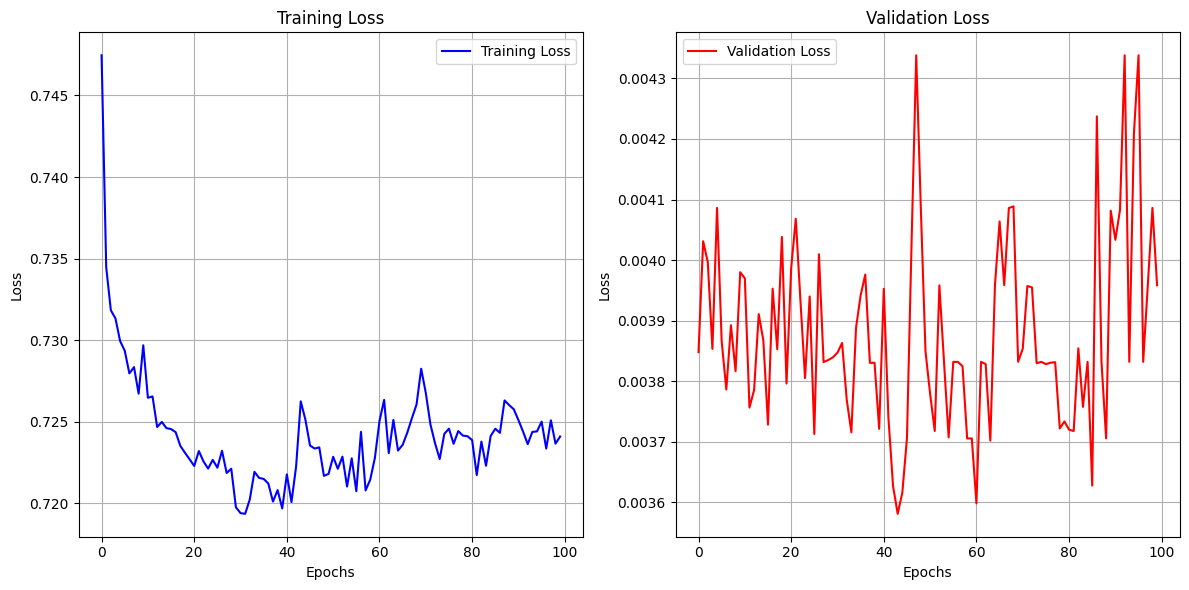

In [14]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot training loss on the first subplot
axs[0].plot(train_losses_complete, color='b', label='Training Loss')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot validation loss on the second subplot
axs[1].plot(val_losses_complete, color='r', label='Validation Loss')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

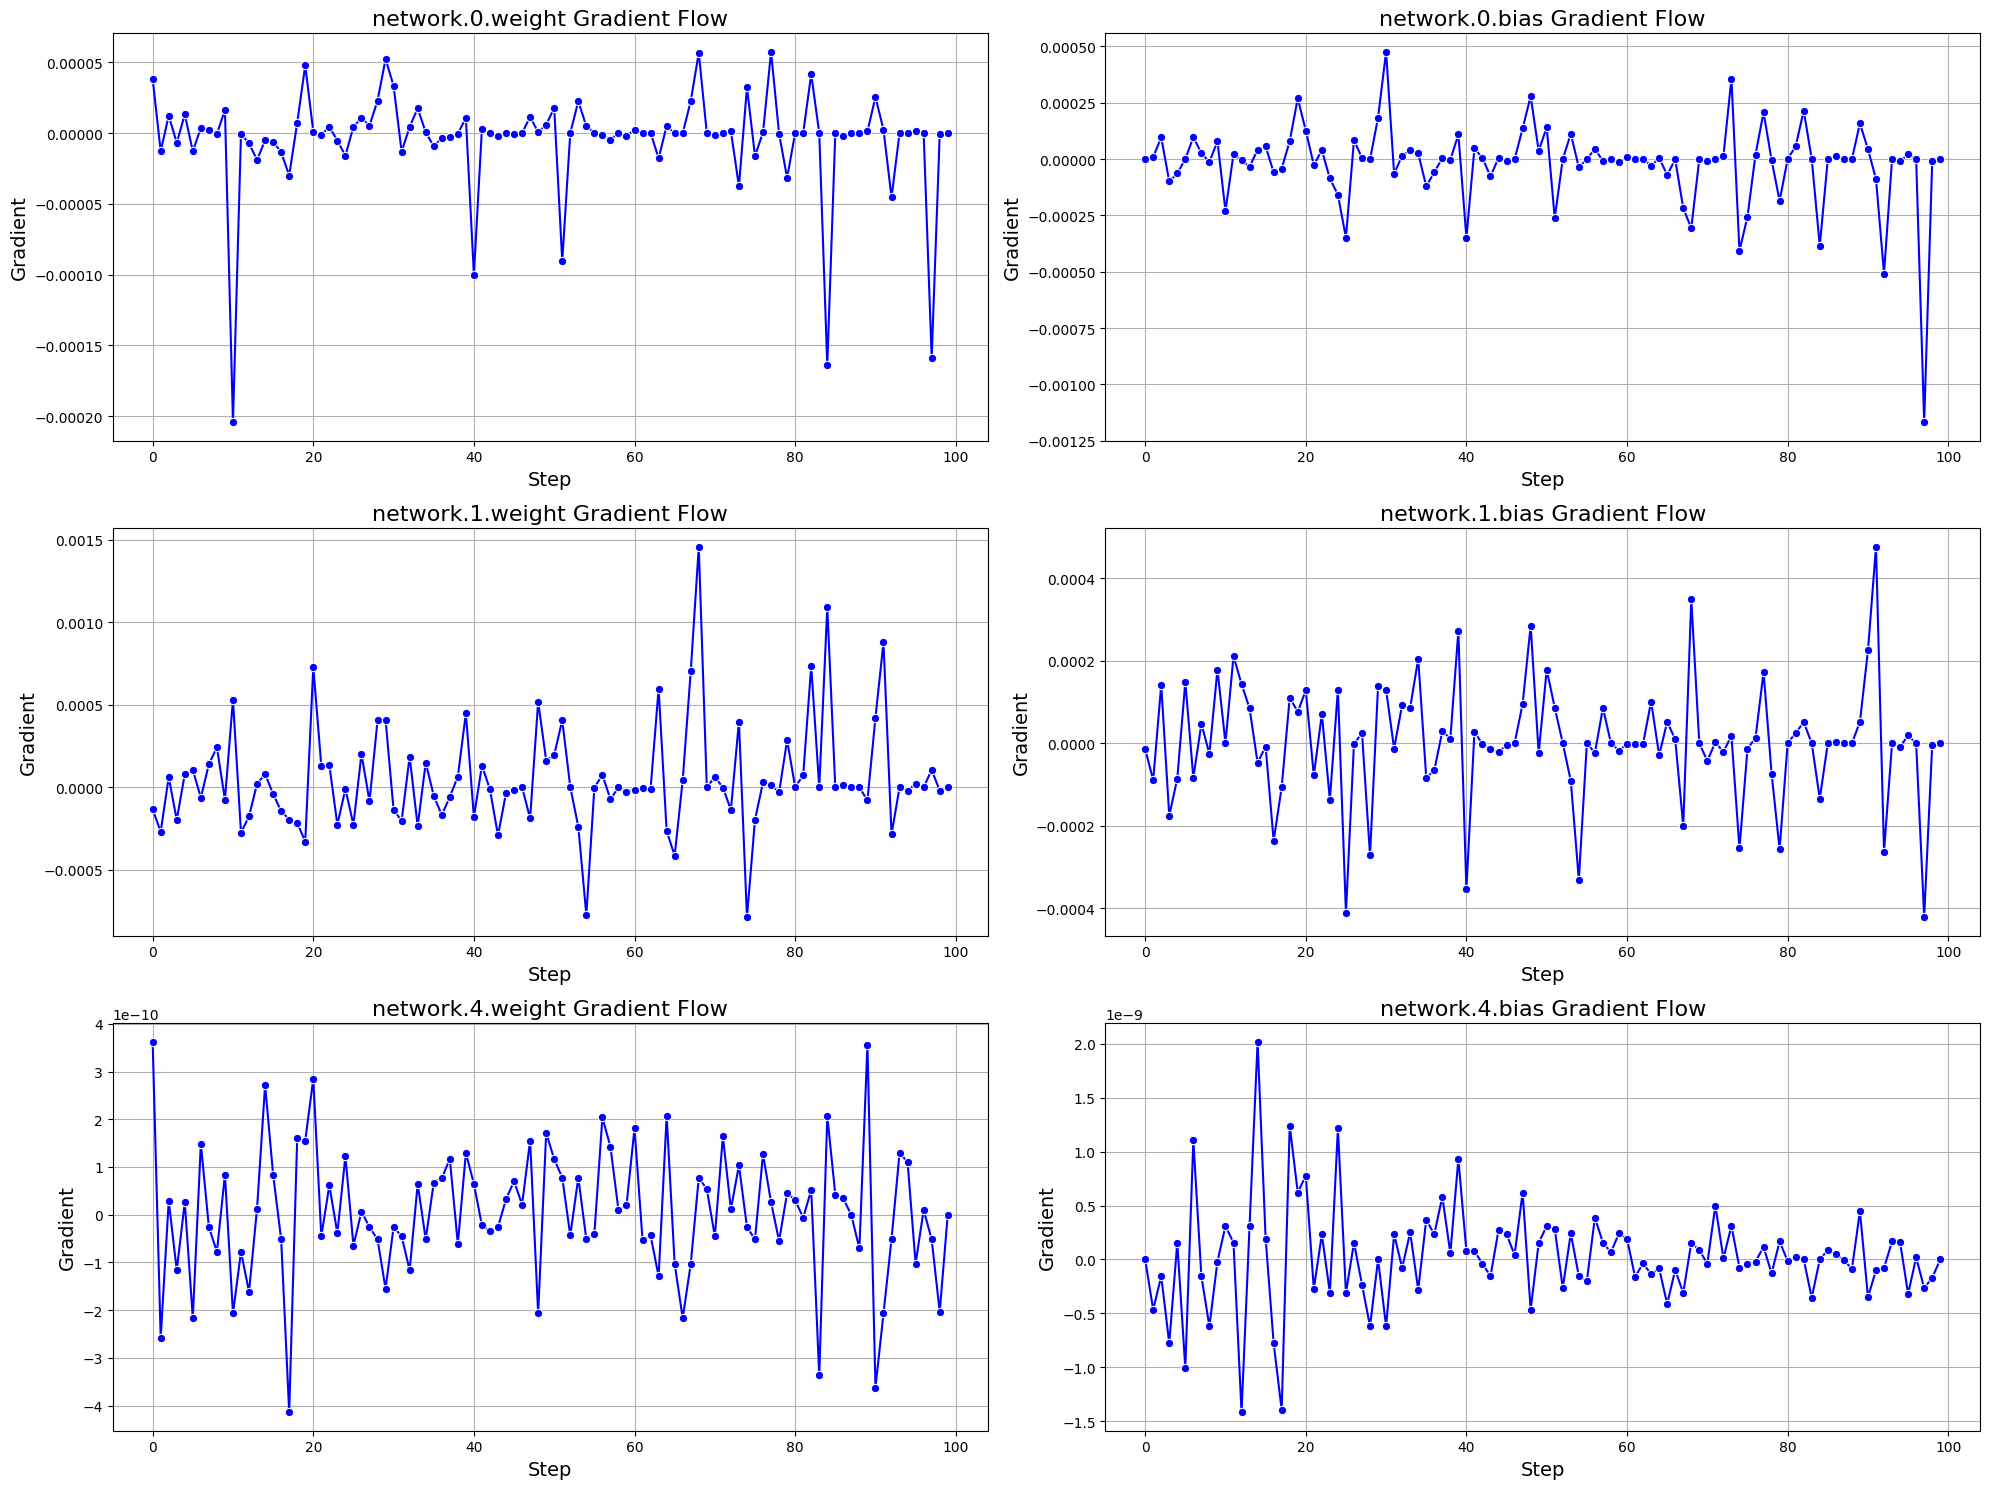

In [15]:
# Number of features to plot
num_features = len(gradients_complete.keys())

# Define the layout of subplots (rows x columns). Adjust as needed.
num_cols = 2  # Adjust the number of columns as needed for better visualization
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows needed

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))  # Adjust the figure size dynamically based on the number of rows

# Flatten the axes array for easy iteration if more than one column
axes = axes.flatten() if num_features > 1 else [axes]

# Loop through each feature and plot
for i, (name, grad) in enumerate(gradients_complete.items()):
    # Assuming 'grad' is a list or numpy array of gradient values
    steps = np.arange(len(grad))  # Create a steps array assuming grad values are ordered by training steps
    sns.lineplot(x=steps, y=grad, ax=axes[i], marker='o', linestyle='-', color='b')  # You can customize the marker, linestyle, and color
    axes[i].set_title(f"{name} Gradient Flow", fontsize=16)
    axes[i].set_xlabel('Step', fontsize=14)
    axes[i].set_ylabel('Gradient', fontsize=14)
    axes[i].grid(True)  # Adding grid lines for better readability

# Hide any unused subplots
for i in range(num_features, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()